## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [25]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from math import sqrt

%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [26]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [27]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [28]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [29]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [30]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [32]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [33]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [34]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [35]:
df2[df2['user_id'].duplicated() == True]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [36]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [37]:
df2 = df2.drop_duplicates(subset = {'user_id'})

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [38]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [39]:
control_group = df2[df2['group'] == 'control']
control_group['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [40]:
treatment_group = df2[df2['group'] == 'treatment']
treatment_group['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [41]:
df2[df2['landing_page'] == 'new_page'].shape[0]/df2.shape[0]

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**It seems that there's no significant difference in conversion for the new page and the conversion for the old page: the proportions of users receiving each kind of page is roughly the same, and the mean conversion is also the same for both the old and the new page.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**The null hypothesis would be: the conversion for the the old page is as good as or better in than the conversion for the new one is.
The alternative hypothesis would be: the conversion rate for the new page is better than for the old page.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [42]:
#p_new = p_old = p_ab
p_null = df2['converted'].mean()
p_null

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [43]:
#p_new = p_old = p_ab
p_null

0.11959708724499628

c. What is $n_{new}$?

In [44]:
gr_new = df2[df2['landing_page'] == 'new_page']
gr_old = df2[df2['landing_page'] == 'old_page']

In [45]:
n_new = gr_new.shape[0]
n_new

145310

d. What is $n_{old}$?

In [46]:
n_old = gr_old.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [47]:
new_page_converted = np.random.binomial(1, p_null, n_new)
new_page_converted

array([0, 0, 0, ..., 0, 1, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [48]:
old_page_converted = np.random.binomial(2, p_null, n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [49]:
new_page_converted.mean() - old_page_converted.mean()

-0.11963091797458926

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [51]:
new_converted_simulation = np.random.binomial(n_new, p_null,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_null,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

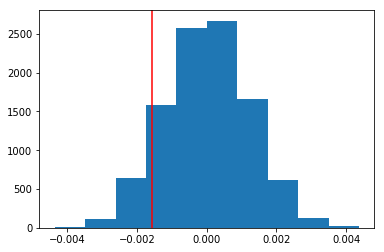

In [52]:
plt.hist(p_diffs);
plt.axvline(treatment_group['converted'].mean() - control_group['converted'].mean(), color = 'red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [53]:
diff_ab = treatment_group['converted'].mean() - control_group['converted'].mean()
greater = p_diffs > diff_ab
greater.mean()

0.9048

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**We computed the p-value, the probability of getting the observer or more extreme result when the null hypothesis is true. In hypothesis testing it is usually compared to some small value called the alpha - the probability of I type error. From our result we can see that the value is quite large, so this means that our value falls in the left half of the theoretic distribution. So we cannot reject the null hypothesis, and this means our convert rates are equal.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [54]:
import statsmodels.api as sm

convert_old = control_group['converted'].sum()
convert_new = treatment_group['converted'].sum()
n_old = gr_old.shape[0]
n_new = gr_new.shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [55]:
sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Proportions_ztest returns the z-statistic and the p-value for the given samples. We can see that we got the p-value quite close to the one got from the simulation, and the p-value is large enough not to reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We need to perform logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [56]:
df2['intercept'] = 1
df2['ab_page'] = (df2['group'] == 'treatment') * 1 # a trick to transform boolean into int
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [57]:
md_log = sm.Logit(df2['converted'], df2[['ab_page', 'intercept']])
results = md_log.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [58]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        19:21:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br> 

**The p-value associated with ab_page is 0.19. This is different from the value we found in Part II as our hypotheses have changed: in Parts I and II we were conducting one-tailed tests, while in Part III the regression is only concerned if there was any change and there is no question if it was positive or negative, so it is a two-tailed test.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**The more terms there are, the more complex our model will be, and starting from some point the growth in R squared will be insignificant.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion? Provide the statistical output as well as a written response to answer this question.

In [59]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [60]:
df3 = df2.join(df_countries.set_index('user_id'), on = 'user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [61]:
dum_country = pd.get_dummies(df3['country'])
df3 = df3.join(dum_country)
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [62]:
md_log = sm.Logit(df3['converted'], df3[['ab_page', 'intercept', 'CA', 'UK']])
results = md_log.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [63]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 16 Oct 2018   Pseudo R-squ.:               2.323e-05
Time:                        19:21:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**We can see that the coefficients associated with both the countries and the page type are really small, with the p-values being quite large, so it is quite possible that they have very little or no effect on the dependant variable.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [64]:
df3['ab_page * CA'] = df3['ab_page'] * df3['CA']
df3['ab_page * UK'] = df3['ab_page'] * df3['UK']
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,ab_page * CA,ab_page * UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [65]:
md_log = sm.Logit(df3['converted'], df3[['ab_page', 'intercept', 'CA', 'UK', 'ab_page * CA', 'ab_page * UK']])
results = md_log.fit();
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 16 Oct 2018   Pseudo R-squ.:               3.482e-05
Time:                        19:21:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ab_page         -0.0206      0.014     -1.505      0.132      -0.047       0.006
intercept       -1.9865      0.010   -206.344      0.000      -2.005      -1.968
CA              -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK              -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page * CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
ab_page * UK     0.0314      0.027      1.181      0.238      -0.021       0.084
================================================================================
"""

**We can again see that all the coefficients except the intercept are close to zero and the p-values for them are quite large meaning that their difference from zero is not statistically significant. So we can tell that adding the interactions between page and country did not improve our model.**